
#  
<center>
University of ain temouchent
<br>
Department of Mathematics and Computer Science
<br> <br>  

<table >
    <tr>
        <td><center><h5>   Master 2  </h5>
        <h5>Cybersecurity and artificial intelligence</h5>
        </center></td>
    </tr>
</table>

<br> <br>

</center>

---



# <center> **deep learning**
## <center> **COVID-19 images classification**

---



**By :**

*   Kaddache mohammed el amine
*   Elmeguenni nabil


---

<center>
<br> <br>
<h2>2024-2025</center>




# Data skimming

<ipython-input-4-644225014ec6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette='viridis')


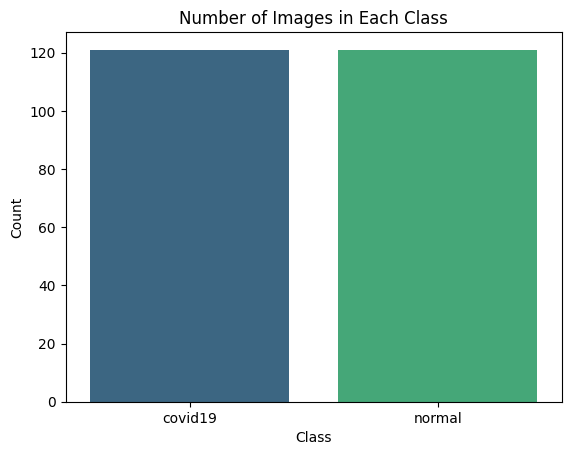

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt


image_counts = {
    'covid19': len(os.listdir('COVID19/covid19')),
    'normal': len(os.listdir('COVID19/normal'))
}

sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette='viridis')
plt.title("Number of Images in Each Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


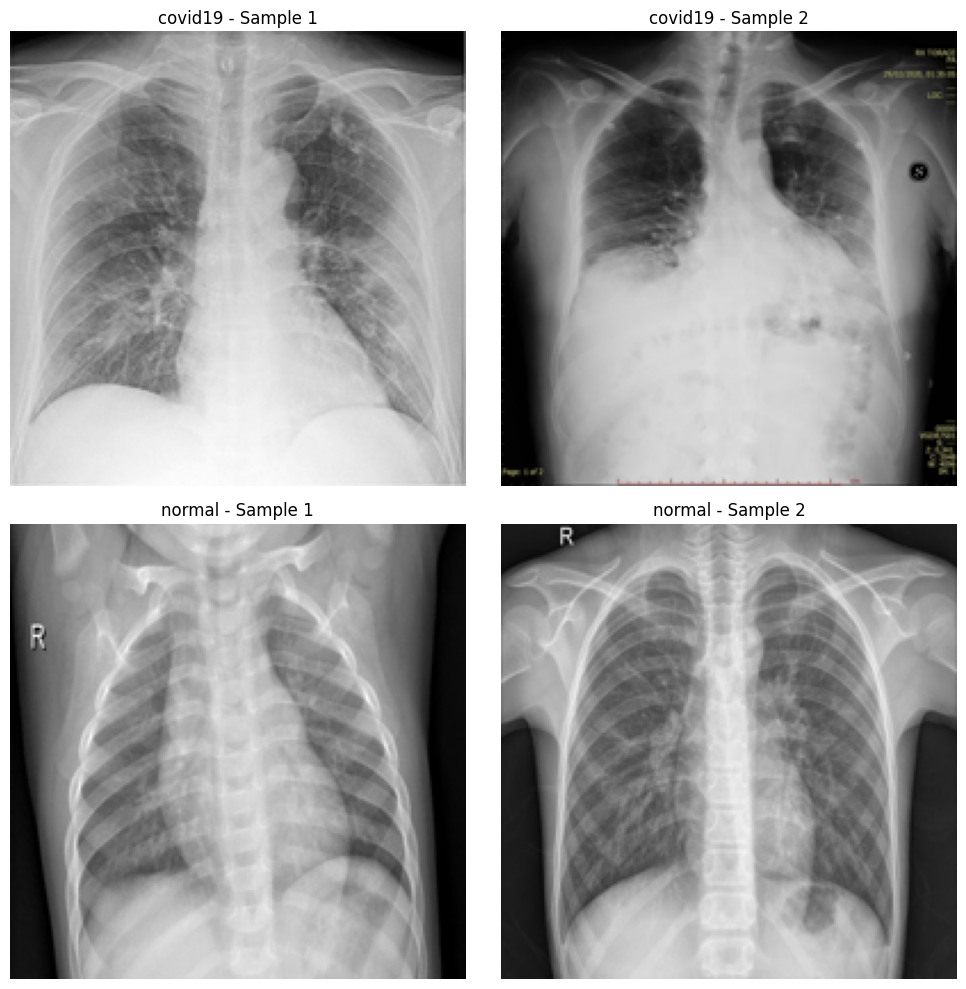

In [ ]:

from PIL import Image
import matplotlib.image as mpimg
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i, cls in enumerate(['covid19', 'normal']):
    class_path = f'COVID19/{cls}'
    sample_images = os.listdir(class_path)[:2]
    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).resize((200, 200))
        axes[i * 2 + j].imshow(np.array(img))
        axes[i * 2 + j].set_title(f'{cls} - Sample {j + 1}')
        axes[i * 2 + j].axis('off')

plt.tight_layout()
plt.show()



# image segmentation

In [ ]:
!pip install scikit-fuzzy

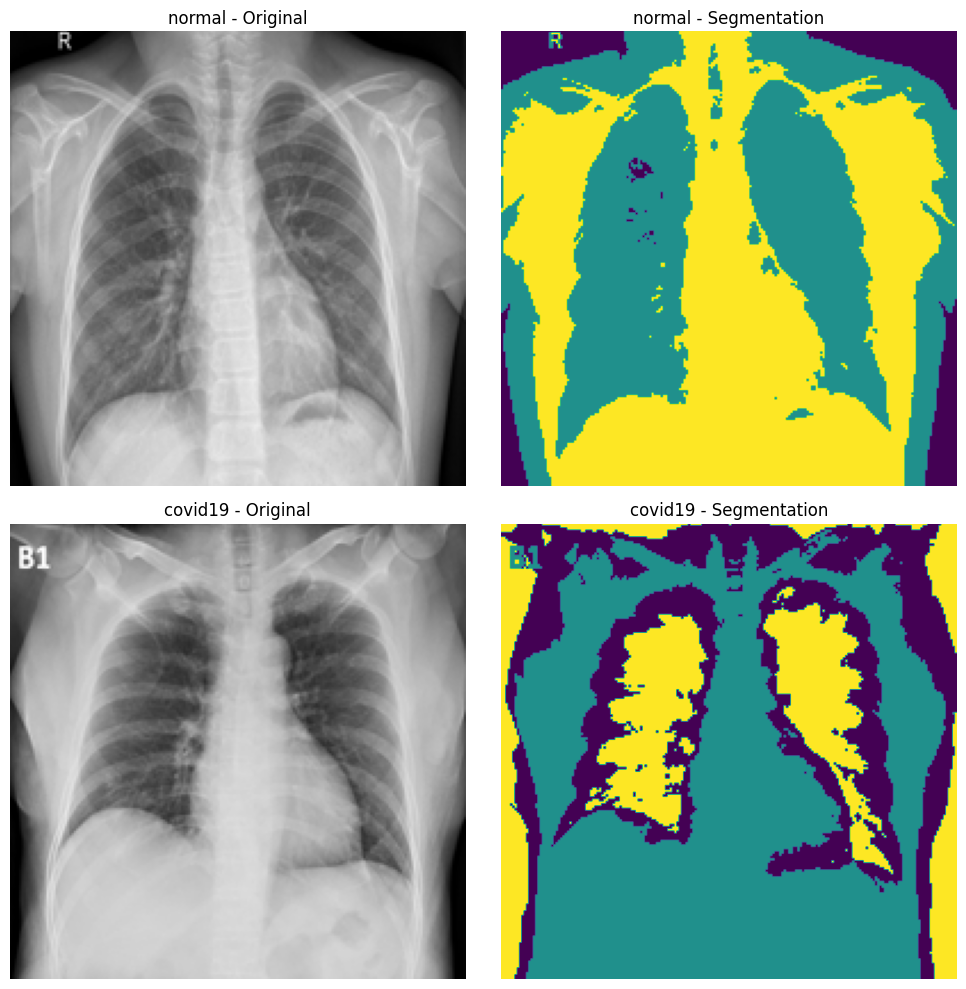

In [ ]:
import cv2
import numpy as np
import skfuzzy as fuzz
from skimage.color import rgb2gray


selected_images = {}
for cls in ['covid19', 'normal']:
    class_path = f'COVID19/{cls}'
    img_name = os.listdir(class_path)[15]
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path).resize((200, 200))
    selected_images[cls] = np.array(img)


fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i, cls in enumerate(['normal', 'covid19']):
    img = selected_images[cls]
    gray_img = rgb2gray(img)
    pixels = gray_img.flatten()


    n_clusters = 3
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data=pixels.reshape(1, -1),
        c=n_clusters,
        m=2.0,
        error=0.005,
        maxiter=1000,
        init=None
    )
    cluster_labels = np.argmax(u, axis=0).reshape(gray_img.shape)


    axes[i * 2].imshow(img)
    axes[i * 2].set_title(f'{cls} - Original')
    axes[i * 2].axis('off')


    axes[i * 2 + 1].imshow(cluster_labels, cmap='viridis')
    axes[i * 2 + 1].set_title(f'{cls} - Segmentation')
    axes[i * 2 + 1].axis('off')

plt.tight_layout()
plt.show()


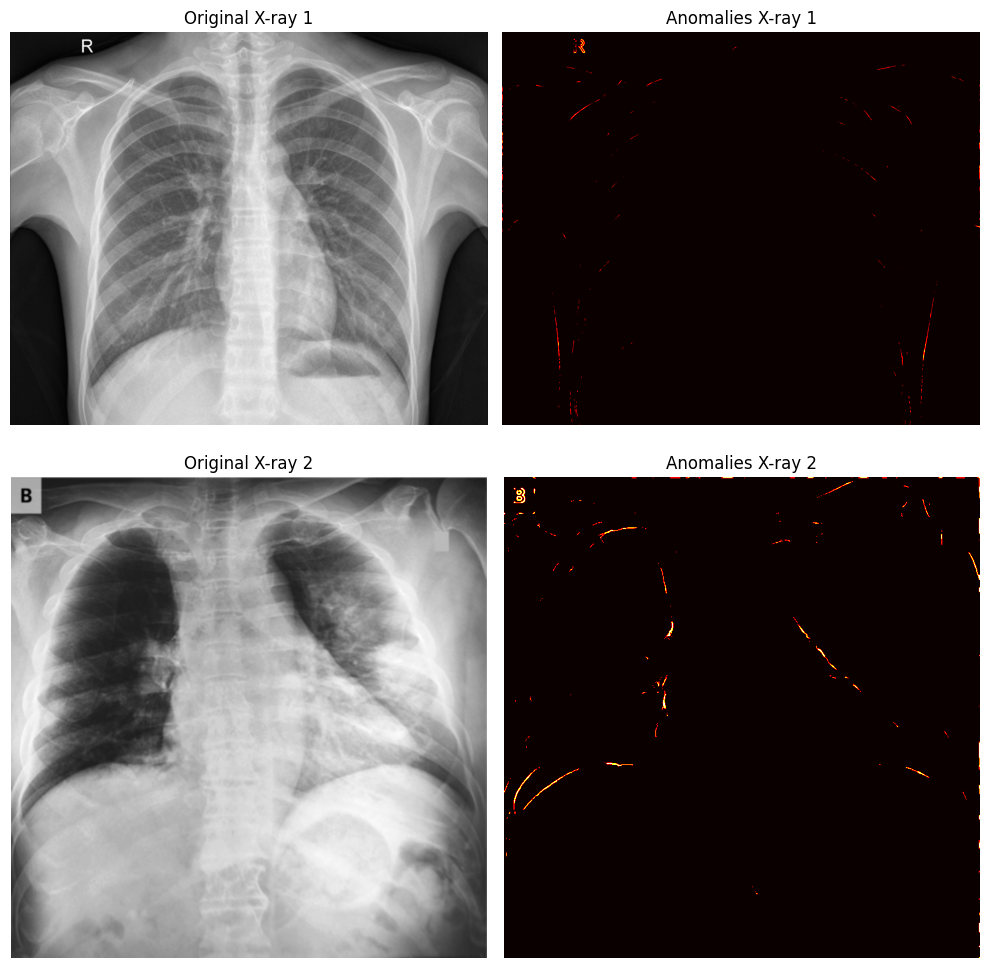

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def process_image(image_path, eps, min_samples):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


    image = cv2.GaussianBlur(image, (5, 5), 0)


    h, w = image.shape
    X = []
    for i in range(h):
        for j in range(w):
            X.append([i, j, image[i, j]])

    X = np.array(X)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)

    anomalies = labels == -1
    anomalies_image = anomalies.reshape(h, w)

    return image, anomalies_image


image1_path = "COVID19/normal/0.png"
image2_path = "COVID19/covid19/1.png"

image1, anomalies1 = process_image(image1_path, eps=5, min_samples=10)
image2, anomalies2 = process_image(image2_path, eps=5, min_samples=10)


plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title("Original X-ray 1")
plt.imshow(image1, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Anomalies X-ray 1")
plt.imshow(anomalies1, cmap='hot')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Original X-ray 2")
plt.imshow(image2, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Anomalies X-ray 2")
plt.imshow(anomalies2, cmap='hot')
plt.axis('off')

plt.tight_layout()
plt.show()


# Simple CNN

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import classification_report, accuracy_score


dataset_path = "COVID19"
classes = ['covid19', 'normal']
IMG_SIZE = (64, 64)
BATCH_SIZE = 16
EPOCHS = 15


images = []
labels = []

for label, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)

images = np.array(images) / 255.0
labels = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)


def build_simple_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


model = build_simple_cnn()

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


y_pred = (model.predict(x_test) > 0.5).astype(int).flatten()
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


model.save("simple_cnn_model.h5")



Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5494 - loss: 0.6957 - val_accuracy: 0.7347 - val_loss: 0.6380
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.7388 - loss: 0.6097 - val_accuracy: 0.8571 - val_loss: 0.4099
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8413 - loss: 0.3605 - val_accuracy: 0.9184 - val_loss: 0.2036
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9546 - loss: 0.1710 - val_accuracy: 0.8980 - val_loss: 0.2046
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9382 - loss: 0.1636 - val_accuracy: 0.8776 - val_loss: 0.1893
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9262 - loss: 0.1540 - val_accuracy: 0.9184 - val_loss: 0.1517
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9311 - loss: 0.1305 - val_accuracy: 0.8980 - val_loss: 0.2406
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9542 - loss: 0.1458 - val_accuracy: 0.8776 - val_los

Accuracy: 0.8979591836734694
              precision    recall  f1-score   support

           0       0.95      0.84      0.89        25
           1       0.85      0.96      0.90        24

    accuracy                           0.90        49
   macro avg       0.90      0.90      0.90        49
weighted avg       0.90      0.90      0.90        49





1.   acc=(Tp+TN)/(TP+FP+TN+FN)
2.   recall=Tp/(TP+FN)
3.   pre=(TP)/(TP+FP)
4.   f1 score=2 X (pre X recall)/(pre + recall)


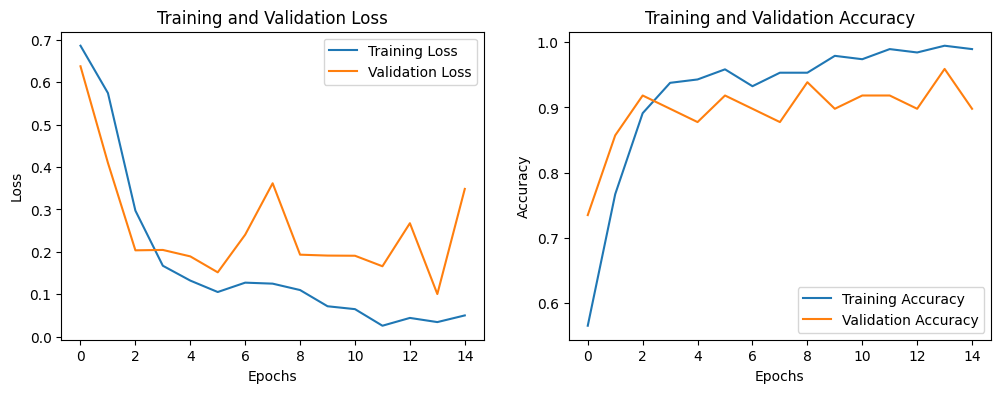

In [ ]:
import matplotlib.pyplot as plt

# رسم منحنى الخسارة (Loss)
plt.figure(figsize=(12, 4))

# خسارة التدريب
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# دقة التدريب
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


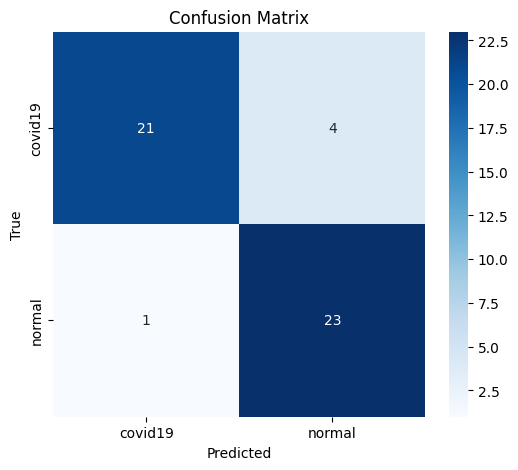

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# حساب مصفوفة الالتباس
cm = confusion_matrix(y_test, y_pred)

# رسم مصفوفة الالتباس
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# data augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


input_image_path = '0.png'
image = Image.open(input_image_path)
image = image.convert('RGB')
image = image.resize((224, 224))
image_array = np.array(image)
image_array = np.expand_dims(image_array, axis=0)


data_gen = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)




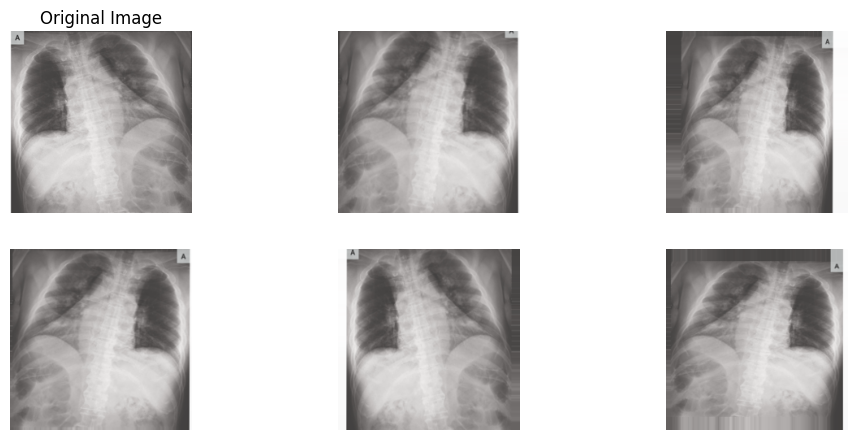

In [ ]:

augmented_images = data_gen.flow(image_array, batch_size=1)


plt.figure(figsize=(12, 8))

plt.subplot(3, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')


for i in range(1, 6):
    plt.subplot(3, 3, i + 1)
    batch = next(augmented_images)
    augmented_image = batch[0].astype('uint8')
    plt.imshow(augmented_image)
    plt.axis('off')


plt.show()

Found 182 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Validation Accuracy: 0.9333


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:32:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


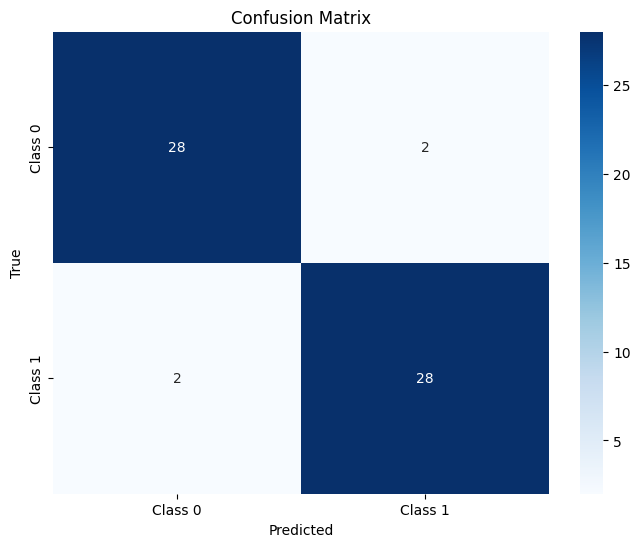

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_dir = "COVID19"
batch_size = 16
img_size = (64, 64)


train_gen = ImageDataGenerator(rescale=1.0/255,shear_range=0.2,zoom_range=0.2,validation_split=0.25,horizontal_flip =True)
train_data = train_gen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', subset='training')
val_data = train_gen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', subset='validation')


feature_extractor = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5)
])

def extract_features(data_generator, model):
    features = []
    labels = []
    for batch_images, batch_labels in data_generator:
        batch_features = model.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)
        if len(features) * batch_size >= data_generator.samples:
            break
    return np.vstack(features), np.hstack(labels)

train_features, train_labels = extract_features(train_data, feature_extractor)
val_features, val_labels = extract_features(val_data, feature_extractor)


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(train_features, train_labels)

val_predictions = xgb_model.predict(val_features)
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {accuracy:.4f}")


cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['covid19', 'normal'], yticklabels=['covid19', 'normal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

xgb_model.save_model("covid19_xgboost.json")


# MobileNet pretrained

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNet base model
base = MobileNet(weights="imagenet", input_shape=(224, 224, 3), include_top=False)

# Set base model layers as non-trainable
for layer in base.layers:
    layer.trainable = False



# Data augmentation and preprocessing
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.25,
    horizontal_flip=True
)

train = train_datagen.flow_from_directory(
    "COVID19/",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val = train_datagen.flow_from_directory(
    "COVID19/",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

class_names = ['covid19', 'normal']

# Build the model
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(base)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))



# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    train,
    epochs=30,
    validation_data=val
)

# Save the model
model.save('mobilenet_epoch_30.h5')



Found 182 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7749 - loss: 2.2247 - val_accuracy: 0.9667 - val_loss: 0.2087
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9712 - loss: 0.1974 - val_accuracy: 0.9167 - val_loss: 0.7555
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9781 - loss: 0.4749 - val_accuracy: 1.0000 - val_loss: 0.0107
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9943 - loss: 0.0391 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9877 - loss: 0.0889 - val_accuracy: 0.9667 - val_loss: 0.2976
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9625 - loss: 0.1640 - val_accuracy: 0.9667 - val_loss: 0.0332
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9932 - loss: 0.0719 - val_accuracy: 1.0000 - val_loss: 6.5940e-04
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 1.0000 - loss: 2.6110e-04 - val_accuracy: 0.9833 - val_loss: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step

Classification Report:

              precision    recall  f1-score   support

     covid19       0.53      0.53      0.53        30
      normal       0.53      0.53      0.53        30

    accuracy                           0.53        60
   macro avg       0.53      0.53      0.53        60
weighted avg       0.53      0.53      0.53        60



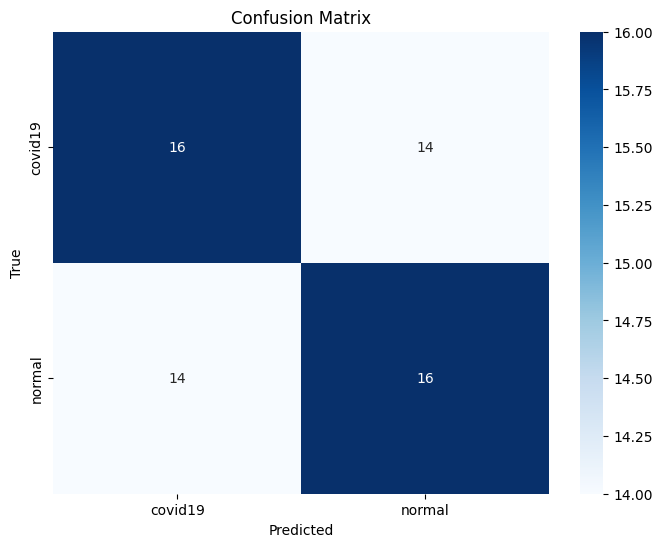

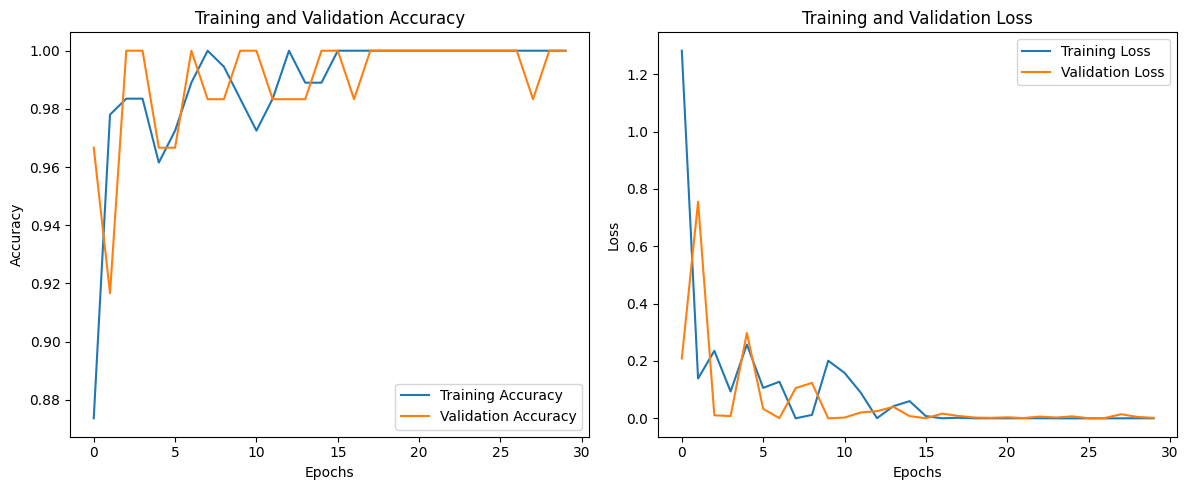

In [ ]:
# Evaluate the model
val_predictions = model.predict(val)
y_pred = np.argmax(val_predictions, axis=1)
y_true = val.classes

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# xception pretrained model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense,Flatten, Input, Dropout

In [ ]:
base = Xception(weights="imagenet", input_shape =(299,299,3),include_top= False)

for layers in base.layers:
 layers.trainable=False
base.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
batch_size=16
train_datagen = ImageDataGenerator(
 rescale=1./255,
 shear_range=0.2,
 zoom_range=0.2,
 validation_split=0.25,
 horizontal_flip =True
 )

train =train_datagen.flow_from_directory(
 "COVID19/",
 target_size=(299, 299),
 batch_size=batch_size,
 class_mode='categorical',
 subset='training')
val =train_datagen.flow_from_directory(
 "COVID19/",
 target_size=(299, 299),
 batch_size=batch_size,
 class_mode='categorical',
 subset='validation')

class_names=['covid19','normal']


Found 182 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Input(shape =(299,299,3)))
model.add(base)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dense(2,activation='softmax'))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 10, 2048)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │       3,276,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,138,330 (92.08 MB)

 Trainable params: 3,276,850 (12.50 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


model.fit(
    train,
    epochs=30,
    validation_data=val
)


model.save('epoch_30.h5')


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.7858 - loss: 0.9041 - val_accuracy: 0.9667 - val_loss: 0.2692
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 857ms/step - accuracy: 0.9149 - loss: 2.5627 - val_accuracy: 0.8667 - val_loss: 5.1477
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 810ms/step - accuracy: 0.9118 - loss: 3.9253 - val_accuracy: 0.9667 - val_loss: 0.7954
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 705ms/step - accuracy: 0.9819 - loss: 0.1702 - val_accuracy: 0.9333 - val_loss: 2.1015
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 921ms/step - accuracy: 0.9620 - loss: 1.1825 - val_accuracy: 0.9833 - val_loss: 0.4063
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 847ms/step - accuracy: 0.9826 - loss: 0.4701 - val_accuracy: 0.9833 - val_loss: 0.8001
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 917ms/step - accuracy: 0.9992 - loss: 0.0204 - val_accuracy: 0.9667 - val_loss: 1.1227
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 825ms/step - accuracy: 0.9918 - loss: 0.0855 - val_accuracy: 0.9667 -

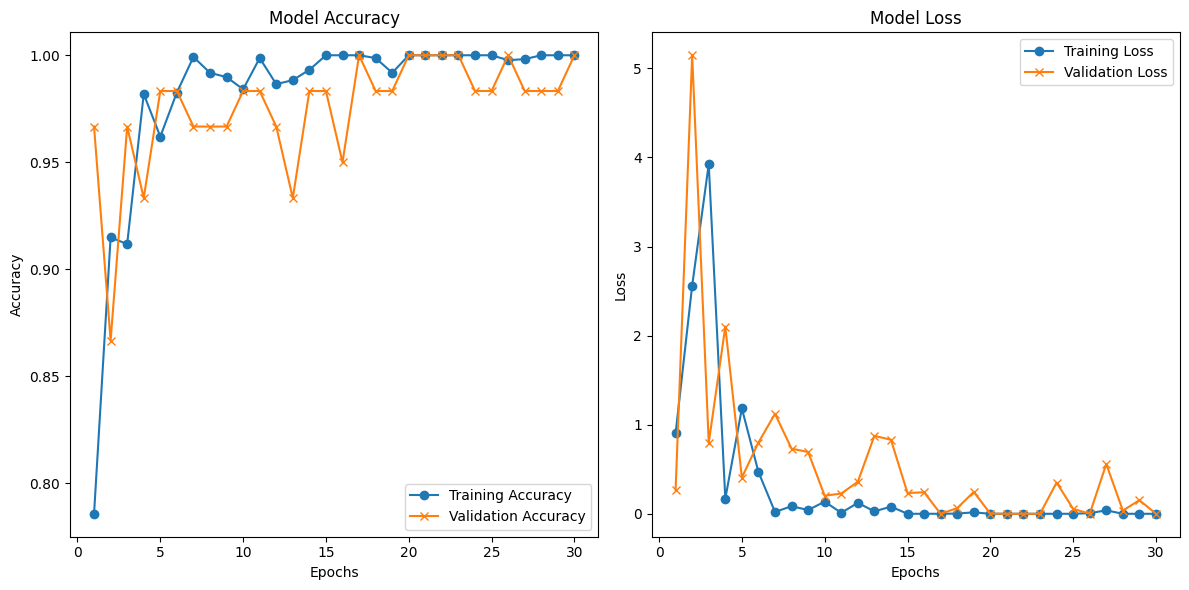

In [ ]:
import matplotlib.pyplot as plt

accuracy = [0.7858, 0.9149, 0.9118, 0.9819, 0.9620, 0.9826, 0.9992, 0.9918, 0.9898, 0.9841,
            0.9987, 0.9865, 0.9884, 0.9932, 1.0000, 1.0000, 1.0000, 0.9987, 0.9918, 1.0000,
            1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9977, 0.9982, 1.0000, 1.0000, 1.0000]
loss = [0.9041, 2.5627, 3.9253, 0.1702, 1.1825, 0.4701, 0.0204, 0.0855, 0.0421, 0.1365,
        0.0110, 0.1229, 0.0271, 0.0805, 0.0000, 0.00016747, 0.0000, 0.0028, 0.0164, 0.0000,
        0.0000, 0.0000, 0.000039299, 0.0000, 0.0000, 0.0073, 0.0388, 0.00000001755, 0.0000, 0.0000]


val_accuracy = [0.9667, 0.8667, 0.9667, 0.9333, 0.9833, 0.9833, 0.9667, 0.9667, 0.9667, 0.9833,
                0.9833, 0.9667, 0.9333, 0.9833, 0.9833, 0.9500, 1.0000, 0.9833, 0.9833, 1.0000,
                1.0000, 1.0000, 1.0000, 0.9833, 0.9833, 1.0000, 0.9833, 0.9833, 0.9833, 1.0000]
val_loss = [0.2692, 5.1477, 0.7954, 2.1015, 0.4063, 0.8001, 1.1227, 0.7314, 0.6937, 0.2026,
            0.2277, 0.3595, 0.8749, 0.8312, 0.2333, 0.2418, 0.000000031789, 0.0640, 0.2453, 0.0022,
            0.0000, 0.0000, 0.00000025034, 0.3503, 0.0552, 0.00067535, 0.5580, 0.0364, 0.1528, 0.00020846]

epochs = range(1, 31)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np


model = tf.keras.models.load_model('epoch_30.h5')


image_path = '200.png'

image = load_img(image_path, target_size=(299, 299))
image_array = img_to_array(image)
image_array = image_array / 255.0
image_array = np.expand_dims(image_array, axis=0)

prediction = model.predict(image_array)
predicted_class = np.argmax(prediction, axis=1)

class_labels = ['covid19', 'normal']
print(f"Predicted Class: {class_labels[predicted_class[0]]}")
print(f"Class Probabilities: {prediction[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: covid19
Class Probabilities: [1.0000000e+00 1.8634956e-33]


Found 60 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Classification Report:
              precision    recall  f1-score   support

     covid19       1.00      1.00      1.00        30
      normal       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



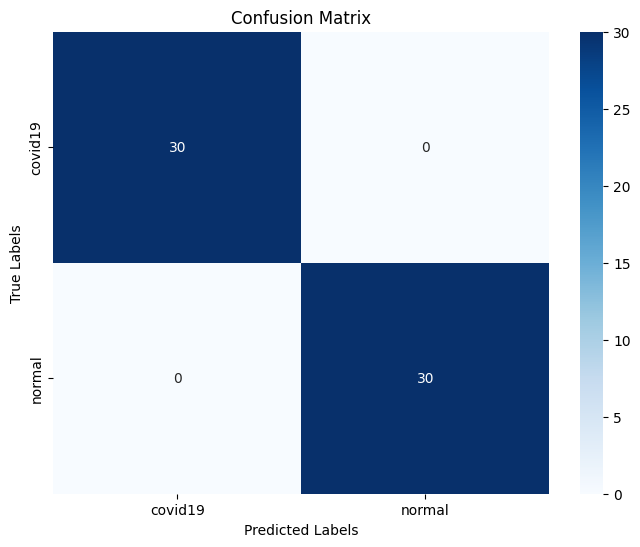

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# تحميل النموذج المدرب مسبقًا
model = load_model('epoch_30.h5')

# إعداد مولد البيانات
image_size = (299, 299)
batch_size = 16

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

# تحميل بيانات الاختبار فقط
val = data_gen.flow_from_directory(
    "COVID19/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# الحصول على التوقعات
predictions = model.predict(val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val.classes

# طباعة معايير التقييم
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(val.class_indices.keys())))

# رسم مصفوفة الارتباك
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(val.class_indices.keys()), yticklabels=list(val.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model


model = load_model('vgg16_model.h5')

model.summary()


for layer in model.layers:
    print(layer.name)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,722,883 (56.16 MB)

 Trainable params: 8,193 (32.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)

input_layer_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten_3
dense


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('vgg16_model.h5')
from tensorflow.keras.preprocessing import image
import numpy as np

ph='COVID19/covid19/0.png'
img = image.load_img(ph, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize if needed
import tensorflow as tf
import cv2
from tensorflow.keras import backend as K

def grad_cam(input_model, image, layer_name):

    grad_model = tf.keras.models.Model(
        inputs=[input_model.inputs],
        outputs=[input_model.get_layer(layer_name).output, input_model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    conv_output = conv_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap


heatmap = grad_cam(model, img_array, 'block5_conv3')



img = cv2.imread(ph)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('grad_cam.png', superimposed_img)


True

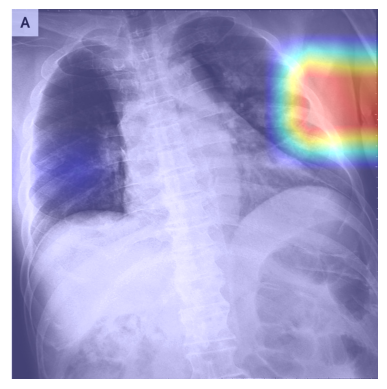

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread('grad_cam.png')


plt.imshow(img)
plt.axis('off')
plt.show()


# GRADIO interface

In [ ]:

!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import cv2


prediction_model = tf.keras.models.load_model('epoch_30.h5')
vgg16_model = tf.keras.models.load_model('vgg16_model.h5')

class_labels = ['covid19', 'normal']


def predict(image):

    image_resized = image.resize((299, 299))
    img_array = img_to_array(image_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    prediction = prediction_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)

    return class_labels[predicted_class[0]], prediction[0].tolist()


def grad_cam(input_model, image, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=[input_model.inputs],
        outputs=[input_model.get_layer(layer_name).output, input_model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap


def generate_gradcam(image):

    original_image = np.array(image)
    img_resized = cv2.resize(original_image, (128, 128))
    img_array = img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    heatmap = grad_cam(vgg16_model, img_array, 'block5_conv3')


    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


    superimposed_img = heatmap * 0.4 + original_image
    return superimposed_img.astype(np.uint8)


def process_image(image):
    pred_class, probabilities = predict(image)
    gradcam_image = generate_gradcam(image)
    return pred_class, probabilities, gradcam_image


iface = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=[
        gr.Textbox(label="Predicted Class"),
        gr.JSON(label="Class Probabilities"),
        gr.Image(label="Grad-CAM Visualization")
    ],
    live=True
)

iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://85e2e0d428be3f07f0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
